# Optimising (further?) a Typewriter

I read this [very interesting article](https://hardmath123.github.io/crown-typewriter.html) a few days ago. I found this very interesting, and I wanted to see If I could 

* Reproduce the result
* Try a constraints solver for this issue
* Maybe try to solve other related problems

So let's start with the beginning, and load the data. Wa want to use the same dataset to compare the results!

## Loading the data


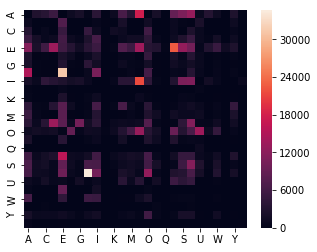

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string

alphabet= string.ascii_uppercase
infile = open('digraphs.txt', 'r')
digraph_matrix=np.empty([len(alphabet), len(alphabet)])
index=0
for line in infile:
    line = line.replace('\n', '').replace('{', '').replace('},', '').replace('}', '').replace(' ', '')
    digraph_matrix[index]=line.split(',')  
    index+=1
infile.close()

df = pd.DataFrame(digraph_matrix, index=list(alphabet),columns=list(alphabet))
fig, ax = plt.subplots(figsize=(5,4))         # Sample figsize in inches

p1 = sns.heatmap(df)
#Seems ok to me

# Cleaning the data
The result is ok, but two things could be better:

* We will use this matrix to calculate the cost of movement. So the diagonal might as well be zero, cause it costs us nothing
* From the same line of thinking, we don't care about A-->B or B-->A. We might as well sum to the half matrix.

In [37]:
summed_digraph=np.add(digraph_matrix,digraph_matrix.transpose())
diag_digraph=np.tril(summed_digraph)

### Cost Function
Let's write the cost function, and check that we fit with the article conclusions

In [38]:
def cost_typewriter(a,b,string):
    #index because we want to know if it is not found
    return abs(string.index(a)-string.index(b))

def test_permutation(string_permutation,cost_function):
    distance_matrix=np.empty([len(string_permutation), len(string_permutation)])
    for index_1,letter_1 in enumerate(alphabet):
        for index_2,letter_2 in enumerate(alphabet):
            distance_matrix[index_1][index_2]=cost_function(letter_1,letter_2,string_permutation)
    score_matrix=np.multiply(distance_matrix, diag_digraph)
    return score_matrix.sum()

test_permutation("ABCDEFGHIJKLMNOPQRSTUVWXYZ",cost_typewriter)
#It's OK with the source! 

9630941.0

### Genetic method

Ok so let's implement a genetic algorihm:

* Start from random permutation
* Try n random swap
* Chooses the best 

I threaded it, using the information from this [very interesting article](https://medium.com/@bfortuner/python-multithreading-vs-multiprocessing-73072ce5600b)

(5499341.0, 'QJXPBYFMULORSETHAINDCWGVKZ')


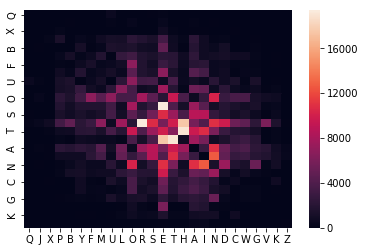

In [39]:
import random 
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from itertools import repeat

def random_permutation():
    alphabet_list= list(string.ascii_uppercase)
    random.shuffle(alphabet_list)
    return ''.join(alphabet_list)

def random_swap(string):
    list_string=list(string)
    indexes=random.sample(range(0,len(string)), 2)
    list_string[indexes[1]],list_string[indexes[0]]=(list_string[indexes[0]],list_string[indexes[1]])
    return ''.join(list_string)

def evolve_string(string,number_test,cost_function):
    best_performance=test_permutation(string,cost_function)
    best_outsider=string
    for i in range(number_test):
        outsider=random_swap(string)
        outsider_score=test_permutation(outsider,cost_function)
        if outsider_score<best_performance:
            best_outsider=outsider
            best_performance=outsider_score
    return best_outsider
    
def genetic_force(seed_size,number_test,stop_cutoff,cost_function):
    #generate seed
    family= [random_permutation() for x in range(seed_size)]
    stop_counter=0
    while stop_counter<stop_cutoff:
        old_family=family.copy()
        with ProcessPoolExecutor(max_workers=seed_size) as executor:
            res = executor.map(evolve_string,family,repeat(number_test),repeat(cost_function))
        family=list(res)
        if old_family==family:
            stop_counter+=1
        else:
            stop_counter=0
        score=[test_permutation(x,cost_function) for x in family]
        arg=np.argsort(score)[0]
    score=[test_permutation(x,cost_function) for x in family]
    arg=np.argsort(score)[0]
    return score[arg],family[arg]

proposition=genetic_force(50,10,5,cost_typewriter)

#Let's plot the heatmap of the result
df = pd.DataFrame(summed_digraph/2, index=list(alphabet),columns=list(alphabet))
df=df[list(proposition[1])]
df=df.reindex(list(proposition[1]))
print(proposition)
p1 = sns.heatmap(df)


### Constraint-based solving

Ok so now, let's try a constraint based method. We use Z3 and find out pretty fast that it won't work. It is far too slow. So the best we can do is to predict how long it would take.

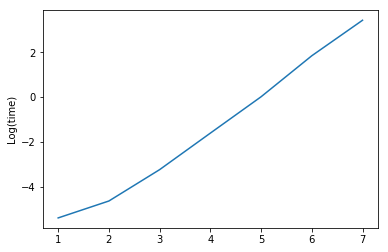

predicted time for 26 letter : 13.31723421267026  million of years


In [43]:
#Note: to install z3 use: pip install z3-solver

from z3 import *
import string
import time
import math
alphabet= string.ascii_uppercase

def diff(x, y):
    return If(x<y, y-x, x-y)

#Z3 does not support matrix operations
def cost_fonction_linear(array):
    sum_cost=0
    for index_1,variable_1 in enumerate(array):
        for index_2,variable_2 in enumerate(array):
            sum_cost+=diag_digraph[index_1][index_2]*diff(variable_1,variable_2)
    return sum_cost

def test_time(numletter):
    start = time.time()
    trunc_alphabet=list(alphabet)[:numletter]
    variable_array=[Int(letter) for letter in trunc_alphabet]
    s=Optimize()
    for var in variable_array:
        s.add(And(var>=0, var<numletter))
    s.add(Distinct(variable_array))
    final_sum=Int("final_sum")
    s.add(final_sum==cost_fonction_linear(variable_array))
    s.minimize(final_sum)
    s.check()
    m=s.model()
    end = time.time()
    return end - start
    
times=[math.log(test_time(x)) for x in range(1,8)]
plt.plot(range(1,8),times)
plt.ylabel('Log(time)')
plt.show()

#Let's get trend
a,b = np.polyfit(range(1,8),times, 1)
print("predicted time for 26 letter :", math.exp(a*27+b)/(60*60*24*365*1000*1000), " million of years")


# How about phones?

I still have a dumphone and I don't like T9. What would be the best letter arrangement? 
Let's put all the constraints here. 

* 7 group of 3 letters, 2 of 4
* Each digraph costs us : 
    * the number of click in the group for the next letter
    * the wait time if the letter is on the same button as the former one (very annoying, last as long as 3 clicks)
    * move time is negligible

In [42]:
def print_string_dumbphone(s):
    print("|---------|",s[0],s[1],s[2],"|",s[3],s[4],s[5],"--|")
    print("|--",s[6],s[7],s[8],"|",s[9],s[10],s[11],"|",s[12],s[13],s[14],"--|")
    print("|",s[15],s[16],s[17],s[18],"|",s[19],s[20],s[21],"|",s[22],s[23],s[24],s[25],"|",)

def cost_dumbphone(a,b,string):
    #costs depends on: does a and b are on same pad, if yes cost is +3, and how many clicks for b
    clickmap=list(range(1,4))*5+list(range(1,5))+list(range(1,4))+list(range(1,5))
    cost = clickmap[string.index(b)]
    #irregular so no smarter way
    buttonlist=[[0,1,2],[3,4,5],[6,7,8],[9,10,11],[12,13,14],[15,16,17,18],[19,20,21],[22,23,24,25]]
    for button in buttonlist:
        if string.index(b)in button and string.index(a)in button:
            return cost+3
    return cost

assert(cost_dumbphone("B","A", "ABCDEFGHIJKLMNOPQRSTUVWXYZ")==4)
assert(cost_dumbphone("A","Z", "ABCDEFGHIJKLMNOPQRSTUVWXYZ")==4)
assert(cost_dumbphone("A","W", "ABCDEFGHIJKLMNOPQRSTUVWXYZ")==1)
assert(cost_dumbphone("U","E", "ABCDEFGHIJKLMNOPQRSTUVWXYZ")==2)

proposition=genetic_force(50,10,5,cost_dumbphone)
print("Total cost is :",proposition[0])
print_string_dumbphone(proposition[1])

Total cost is : 1873076.0
|---------| O S Q | H L J --|
|-- A F U | I B P | E G Y --|
| N R Z X | D T K | C M W V |


Ok now for something a little more relatable. How about smartphones keyboards? Our constraints are a little simpler:

* 3 row:
    * 10 letter in the first one
    * 9 in the second one (half a letter offset)
    * 7 in the third one (one and a half letter offset)
* Cost is euclidian travel distance

In [44]:
def print_string_smartphone(s):
    print(''.join([s[x]+" " for x in range(0,10)]))
    print(' '+ ''.join([s[x]+" " for x in range(10,19)]))
    print('   '+''.join([s[x]+" " for x in range(19,26)]))
    
def cost_smartphone(a,b,string):
    clickmap=[[0,x] for x in range(0,10)]+[[1,x+0.5] for x in range(0,9)]+[[2,x+1.5] for x in range(0,7)]
    coord_a=clickmap[string.index(a)]
    coord_b=clickmap[string.index(b)]
    cost = math.sqrt((coord_a[0]-coord_b[0])**2+(coord_a[1]-coord_b[1])**2)
    return cost

assert(cost_smartphone('A','I',"ABCDEFGHIJKLMNOPQRSTUVWXYZ")==8)
assert(cost_smartphone('A','K',"ABCDEFGHIJKLMNOPQRSTUVWXYZ")==math.sqrt(1.25))
assert(cost_smartphone('A','T',"ABCDEFGHIJKLMNOPQRSTUVWXYZ")==math.sqrt(6.25))
assert(cost_smartphone('V','A',"ABCDEFGHIJKLMNOPQRSTUVWXYZ")==math.sqrt(16.25))

proposition=genetic_force(50,10,5,cost_smartphone)
print("Total cost is :",proposition[0])
print_string_smartphone(proposition[1])


Total cost is : 2284394.0726253474
Z V G N D R M F X Q 
 K C I A E O U P J 
   W H T S L Y B 
